Found 304 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
29084464/29084464 [==============================] - 2s 0us/step
Epoch 1/10
9/9 [==============================] - 27s 2s/step - loss: 1.8645 - accuracy: 0.3934 - val_loss: 0.9292 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 2/10
9/9 [==============================] - 17s 2s/step - loss: 0.9990 - accuracy: 0.6287 - val_loss: 0.7050 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 3/10
9/9 [==============================] - 19s 2s/step - loss: 0.7961 - accuracy: 0.6765 - val_loss: 0.7190 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 4/10
9/9 [==============================] - 20s 2s/step - loss: 0.7956 - accuracy: 0.6691 - val_loss: 0.5824 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/10
9/9 [==============================] - 20s 2s/step - loss: 0.6597 - accuracy: 0.7426 - val_loss: 0.4794 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 6/10
9/9 [==============================] - 21s 2s/st

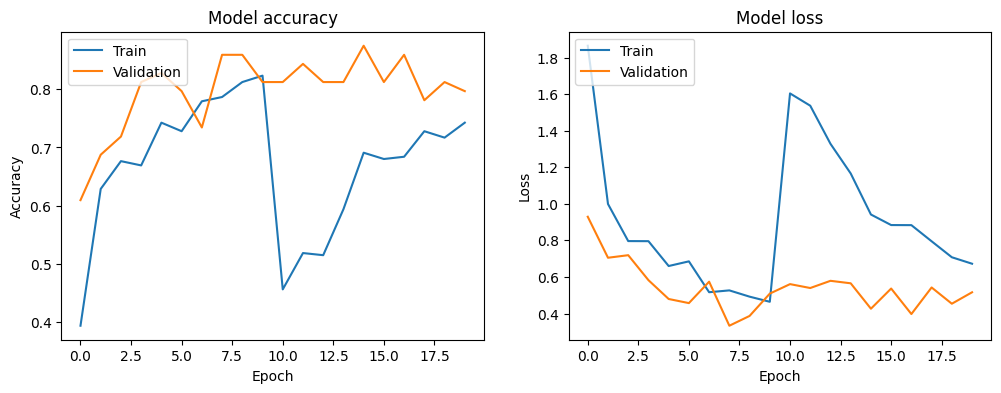

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
import matplotlib.pyplot as plt
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Paths
data_dir = 'dataset_18'
train_dir = 'data_split/train'
validation_dir = 'data_split/validation'
testing_dir = 'data_split/test'

# Ensure directories exist
for dir_path in [train_dir, validation_dir, testing_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Split data
for category in os.listdir(data_dir):
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)
        
        # Copy files to train folder
        train_category_dir = os.path.join(train_dir, category)
        if not os.path.exists(train_category_dir):
            os.makedirs(train_category_dir)
        for img in train_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_category_dir, img))
        
        # Copy files to validation folder
        val_category_dir = os.path.join(validation_dir, category)
        if not os.path.exists(val_category_dir):
            os.makedirs(val_category_dir)
        for img in val_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_category_dir, img))
        
        # Copy files to test folder
        test_category_dir = os.path.join(testing_dir, category)
        if not os.path.exists(test_category_dir):
            os.makedirs(test_category_dir)
        for img in test_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_category_dir, img))

# Define the data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255)
testing_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
testing_generator = testing_datagen.flow_from_directory(testing_dir, target_size=(224, 224), batch_size=1, class_mode=None, shuffle=False)

# Define the pretrained DenseNet model
def pretrained_densenet_model(num_classes):
    base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

# Compile the model
model = pretrained_densenet_model(4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Initial training with frozen layers
history = model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples // 32, 
    epochs=10, 
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // 32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Unfreeze some of the top layers for fine-tuning
for layer in model.layers[-50:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples // 32, 
    epochs=10, 
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // 32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Make predictions on the testing set
testing_predictions = model.predict(testing_generator, steps=testing_generator.samples)

# Get the class predictions
testing_class_predictions = tf.argmax(testing_predictions, axis=1)

# Print the class predictions
print(testing_class_predictions)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Found 304 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/10
9/9 [==============================] - 20s 2s/step - loss: 1.7922 - accuracy: 0.3456 - val_loss: 1.0361 - val_accuracy: 0.5156 - lr: 0.0010
Epoch 2/10
9/9 [==============================] - 13s 1s/step - loss: 1.5132 - accuracy: 0.4559 - val_loss: 1.0489 - val_accuracy: 0.4844 - lr: 0.0010
Epoch 3/10
9/9 [==============================] - 13s 1s/step - loss: 1.3995 - accuracy: 0.4926 - val_loss: 1.1699 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 4/10
9/9 [==============================] - 13s 1s/step - loss: 1.0193 - accuracy: 0.6066 - val_loss: 0.7492 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 5/10
9/9 [==============================] - 13s 1s/step - loss: 0.8618 - accuracy: 0.6691 - val_loss: 0.7025 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 6/10
9/9 [==============================] - 12s 1s/step - loss: 0.7991 - accuracy: 0.6581 - val_loss: 0.7313 - val_acc

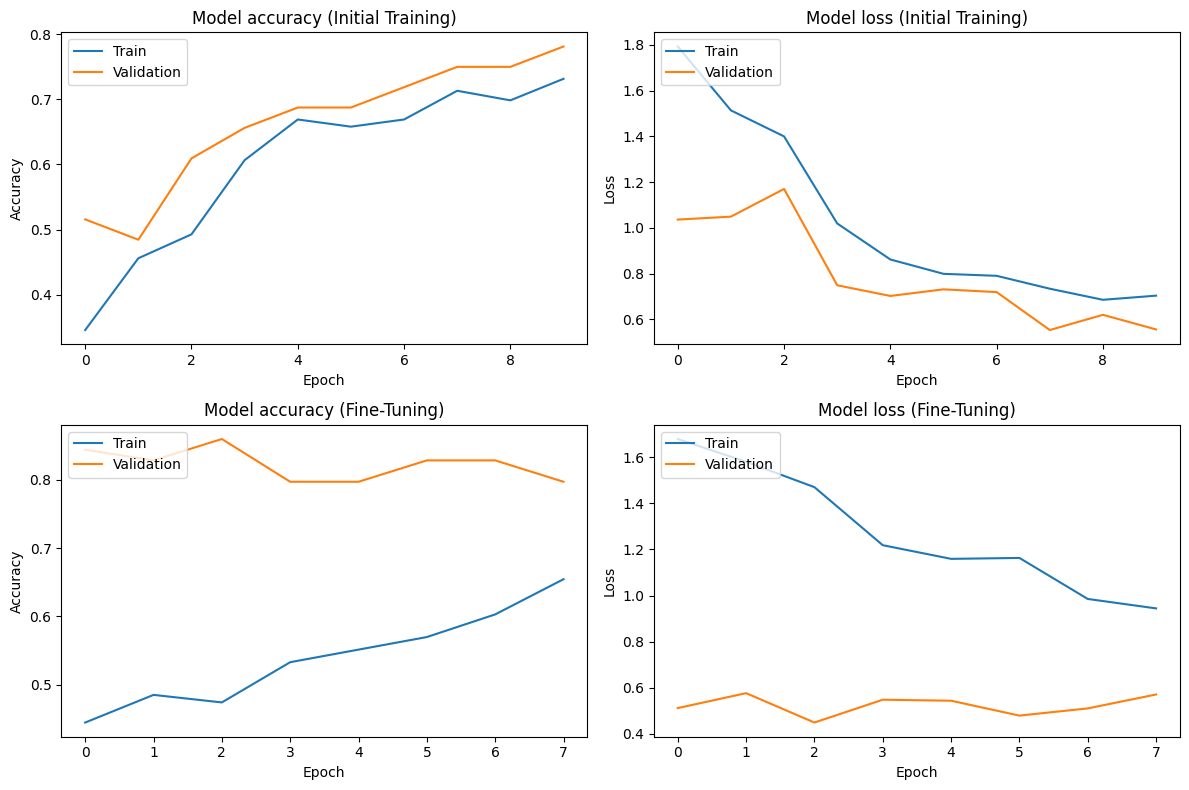

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
import os
import matplotlib.pyplot as plt
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Paths
data_dir = 'dataset_18'
train_dir = 'data_split/train'
validation_dir = 'data_split/validation'
testing_dir = 'data_split/test'

# Ensure directories exist
for dir_path in [train_dir, validation_dir, testing_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Split data
for category in os.listdir(data_dir):
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)
        
        # Copy files to train folder
        train_category_dir = os.path.join(train_dir, category)
        if not os.path.exists(train_category_dir):
            os.makedirs(train_category_dir)
        for img in train_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_category_dir, img))
        
        # Copy files to validation folder
        val_category_dir = os.path.join(validation_dir, category)
        if not os.path.exists(val_category_dir):
            os.makedirs(val_category_dir)
        for img in val_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_category_dir, img))
        
        # Copy files to test folder
        test_category_dir = os.path.join(testing_dir, category)
        if not os.path.exists(test_category_dir):
            os.makedirs(test_category_dir)
        for img in test_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_category_dir, img))

# Define the data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
testing_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
testing_generator = testing_datagen.flow_from_directory(testing_dir, target_size=(224, 224), batch_size=1, class_mode=None, shuffle=False)

# Define the pretrained DenseNet model
def pretrained_densenet_model(num_classes):
    base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

# Compile the model
model = pretrained_densenet_model(4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
lr_scheduler = LearningRateScheduler(scheduler)

# Initial training with frozen layers
history = model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples // 32, 
    epochs=10, 
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // 32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, lr_scheduler]
)

# Unfreeze some of the top layers for fine-tuning
for layer in model.layers[-100:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples // 32, 
    epochs=10, 
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // 32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, lr_scheduler]
)

# Make predictions on the testing set
testing_predictions = model.predict(testing_generator, steps=testing_generator.samples)

# Get the class predictions
testing_class_predictions = tf.argmax(testing_predictions, axis=1)

# Print the class predictions
print(testing_class_predictions)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy (Initial Training)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (Initial Training)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('Model accuracy (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('Model loss (Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
